# Activity Space

With the Point GeoDataFrame, we can measure activity space by building geometric shapes using minimum bounding box methods. There are several ways to build minimum bounding box, including buffer, convex hull, circle, envelope, etc., each with pros and cons depending on the geographic distribution of the Point GeoDataFrame. Currently, we support buffer and convex hull methods in building minimum bounding box and calculating corresponding activity space. The following examples demonstrate how to implement buffer- and convex hull-based activity space. We will use the example data we used in the last section as an example to illustrate how to calculate buffer- and convex hull-based activity space. You can refer to [here](https://github.com/shuai-zhou/gps2space/blob/master/notebooks/createdata.ipynb) for how we compile the data.

We first need to import libraries we will be using for the examples.

In [1]:
%matplotlib inline

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

We then load the data and create spatial data using the `df_to_gdf` method as we did in the last section.

In [2]:
df = pd.read_csv('../data/example.csv')
df.head()

pid                      timestamp   latitude  longitude
0  P2  2020-04-27 10:42:22.162176000  40.993799 -76.669419
1  P2  2020-06-02 01:12:45.308505600  39.946904 -78.926234
2  P2  2020-05-08 23:47:33.718185600  41.237403 -79.252317
3  P2  2020-04-26 14:31:12.100310400  41.991390 -77.467769
4  P2  2020-03-31 15:53:27.777897600  41.492674 -76.542921

There are two persons, P1 and P2, and their locations along with timestamp.

In [3]:
from gps2space import geodf

In [4]:
gdf = geodf.df_to_gdf(df, x='longitude', y='latitude')
gdf.head()

pid                      timestamp   latitude  longitude  \
0  P2  2020-04-27 10:42:22.162176000  40.993799 -76.669419   
1  P2  2020-06-02 01:12:45.308505600  39.946904 -78.926234   
2  P2  2020-05-08 23:47:33.718185600  41.237403 -79.252317   
3  P2  2020-04-26 14:31:12.100310400  41.991390 -77.467769   
4  P2  2020-03-31 15:53:27.777897600  41.492674 -76.542921   

                     geometry  
0  POINT (-76.66942 40.99380)  
1  POINT (-78.92623 39.94690)  
2  POINT (-79.25232 41.23740)  
3  POINT (-77.46777 41.99139)  
4  POINT (-76.54292 41.49267)

In [5]:
pa = gpd.read_file('../data/pacounty.shp')

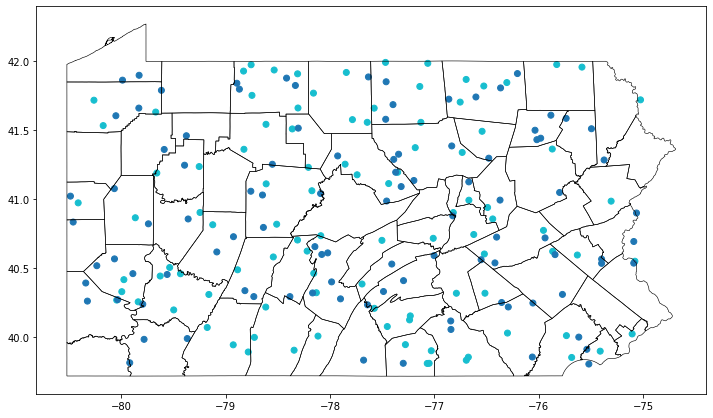

In [6]:
ax = pa.boundary.plot(figsize=(12, 12), edgecolor='black', linewidth=0.6)
gdf.plot(ax=ax, column='pid')

plt.show();

The figure shows the distribution of our data with two different colors representing P1 and P2, respectively.

## Buffer-based activity space

We import the `space` module. The `space` module has a function `buffer_space` which takes four parameters:

- gdf: This is your GeoDataFrame
- dist: This is the buffer distance, the default value is 0 meter
- dissolve: This is the level of aggregating from which you aggregate points to form polygon, the default value is week
- proj: This is the EPSG identifier you want to use to project your spatial data, the default value is 2163

**Please note:** Buffer distance and your projection are related. For raw Lat/Long coordinate pairs (often called unprojected data), the unit is degree. It is not usual to buffer geometry in degrees. You have to decide which projection system is most appropriate for your own data based on the geographical location. For example, **EPSG:2163** is commonly used in the United States, and the unit of distance is meter. See [here](https://epsg.io/) for more information about EPSG identifier.

In this example, we will calculate activity space on a weekly basis. Before that, we need to create a column represents `week` from the timestamp. We will also create `year` and `month` just to show how you can obtain those information from timestamp. It is better to include `infer_datetime_format=True` because this will make `datetime` function much faster, especially when dealing with big data.

In [7]:
gdf['timestamp'] = pd.to_datetime(gdf['timestamp'], infer_datetime_format=True)
gdf['year'] = gdf['timestamp'].dt.year
gdf['month'] = gdf['timestamp'].dt.month
gdf['week'] = gdf['timestamp'].dt.week
gdf.head()

pid                     timestamp   latitude  longitude  \
0  P2 2020-04-27 10:42:22.162176000  40.993799 -76.669419   
1  P2 2020-06-02 01:12:45.308505600  39.946904 -78.926234   
2  P2 2020-05-08 23:47:33.718185600  41.237403 -79.252317   
3  P2 2020-04-26 14:31:12.100310400  41.991390 -77.467769   
4  P2 2020-03-31 15:53:27.777897600  41.492674 -76.542921   

                     geometry  year  month  week  
0  POINT (-76.66942 40.99380)  2020      4    18  
1  POINT (-78.92623 39.94690)  2020      6    23  
2  POINT (-79.25232 41.23740)  2020      5    19  
3  POINT (-77.46777 41.99139)  2020      4    17  
4  POINT (-76.54292 41.49267)  2020      3    14

Now that we have the week column, we can calculate buffer-based activity space on a weekly basis using the `buffer_space` function and pass your choice to the four parameters we mentioned before. In this example, we will use 100 meters as buffer distance and project our data in **EPSG:2163**.

**Please also note** that Pandas use the [ISO week date system](https://en.wikipedia.org/wiki/ISO_week_date) to determine week of a specific date. Sometimes the results is not intuitive, for example:

`print(pd.Timestamp('01-01-2017 12:00:00').week)`

This will give a result of week number 52, rather than week number 1. This is not necessary wrong, see [discussion](https://stackoverflow.com/questions/44372048/python-pandas-timestamp-week-returns-52-for-first-day-of-year/44372130) here. You can work around this issue (if it is a issue to you) by using `DataOffset` (see [discussion](https://stackoverflow.com/questions/53175035/issues-in-getting-week-numbers-with-weeks-starting-on-sunday-in-python) here) like the following (although we do not recommend doing this):

`gdf['week_new'] = (gdf['timestamp'] + pd.DateOffset(days=1)).dt.week`

In [8]:
from gps2space import space

In [9]:
buff_space = space.buffer_space(gdf, dist=100, dissolve='week', proj=2163)

In [10]:
buff_space.head()

week                                           geometry pid  \
0     1  MULTIPOLYGON (((1720869.317 -318189.673, 17208...  P2   
1     2  MULTIPOLYGON (((1825885.684 -276078.791, 18258...  P2   
2     3  MULTIPOLYGON (((1890877.371 -286206.003, 18908...  P2   
3     4  MULTIPOLYGON (((1745374.124 -298916.733, 17453...  P2   
4     5  MULTIPOLYGON (((1940968.545 -274223.560, 19409...  P2   

                      timestamp   latitude  longitude  year  month  \
0 2020-01-05 07:50:30.081292799  40.199583 -79.496295  2020      1   
1 2020-01-09 09:16:06.603628800  40.156435 -77.230625  2020      1   
2 2020-01-16 04:50:28.301625600  40.705452 -78.310757  2020      1   
3 2020-01-26 07:27:26.824550400  41.820474 -76.526561  2020      1   
4 2020-01-31 16:15:44.942918400  40.820036 -78.510162  2020      1   

       buff_area  
0  219558.394338  
1   94096.454716  
2  188192.909433  
3  282289.364149  
4  219558.394338

We can double-check what is the unit in **EPSG:2163** projection system:

In [11]:
buff_space.crs.axis_info[0].unit_name

'metre'

The result is "metre". Accordingly, the `buff_area` column represents the buffer-based activity space measured in square meters on a weekly basis. You probably noticed that this example did not separate P1 and P2 in calculating activity space. Currently, the `dissolve` parameter only accept one string, not a list of strings. To get activity space for each person on a weekly basis is easy, all you need to do is to concatenate `pid` and `week`, then dissolve by the newly created column.

In [12]:
gdf['person_week'] = gdf['pid'].astype(str) + '_' + gdf['week'].astype(str)
buff_space_person_week = space.buffer_space(gdf, dist=100, dissolve='person_week', proj=2163)
buff_space_person_week[['person_week','geometry','year','month','week','buff_area']].head()

person_week                                           geometry  year  month  \
0        P1_1  MULTIPOLYGON (((1743324.165 -263838.253, 17433...  2020      1   
1       P1_10  MULTIPOLYGON (((1910985.055 -311470.562, 19109...  2020      3   
2       P1_11  POLYGON ((1639281.583 -176601.784, 1639281.101...  2020      3   
3       P1_12  MULTIPOLYGON (((2042446.974 -187451.693, 20424...  2020      3   
4       P1_13  MULTIPOLYGON (((1736946.385 -338001.805, 17369...  2020      3   

   week      buff_area  
0     1   94096.454716  
1    10  156827.424527  
2    11   31365.484905  
3    12   62730.969811  
4    13   94096.454716

Now you get the activity space for each person on a weekly basis. Likewise, you can easily get each person's activity space on a yearly basis by simply concatenating `pid` and `year`, or activity space on a monthly basis by simply concatenating `pid` and `month`

You can select the columns you are interested and save the GeoDataFrame to a spatial dataset or non-spatial dataset. Here, we save the GeoDataFrame to a `shp` file and a `csv` file.

In [13]:
buff_space_person_week[['person_week','buff_area','geometry']].to_file('../data/buffer_space.shp')
buff_space_person_week[['person_week','buff_area']].to_csv('../data/buffer_space.csv')

## Convex hull-based space

We can also calculate the convex hull-based activity space using the `convex_space` function. The `convex_space` takes three parameters:

- gdf: This is your GeoDataFrame
- group: This is the level of aggregating from which you group points to form polygon, the default value is week
- proj: This is the EPSG identifier you want to use to project your spatial data, the default value is 2163

In this example, we will dissolve the points by `person_week`

In [14]:
convex_space = space.convex_space(gdf, group='person_week', proj=2163)

In [15]:
convex_space.head()

person_week                                           geometry  convx_area
0        P1_1  POLYGON ((-79.08352 40.61927, -78.64613 41.031...    0.459119
1       P1_10  POLYGON ((-77.29803 39.81326, -78.33096 41.824...    2.980511
2       P1_11                         POINT (-80.05021 41.60526)    0.000000
3       P1_12  LINESTRING (-78.86727 41.79762, -75.39833 40.5...    0.000000
4       P1_13  POLYGON ((-79.36647 39.99230, -77.46196 41.851...    1.425932

The `convx_area` column represents the convex hull-based activity space measured in square meters in **EPSG:2163**. This dataset is not perfect, we see that in Week 11 for P1, there is only one point, therefore a Point shape is constructed and 0 is returned for its area. Similarly, in Week 12 for P1, a line shape is constructed rather than a Polygon and 0 is returned for its area. You can also save this GeoDataFrame to a spatial dataset or a non-spatial dataset just like what we have done for the buffer-based activity space measure.

## Which method to choose

There are pros and cons of the buffer- and convex hull-based measure of activity space. Knowing how they work will help you understand the process and choose the appropriate method.

The following figure shows the buffer-based activity space (in red color) and convex hull-based activity space (in blue color) from a set of Lat/Long coordinate pairs (in black color). In essence, what buffer-based activity space does is: first, draw a circle around every point using specified buffer distance, then dissolve all the buffers into a single feature to form a Polygon. What convex hull-based activity space does is to line up the outermost points and form the polygon.

![buffconvex300](./_static/buffconvex300.png)

The pro of buffer-based activity space is that it works with even only one point where the activity space is eventually the area of the circle. However, you have to specify the buffer distance which sometimes is arbitrary and varies across disciplines.

The convex hull-based activity space does not need any arbitrary parameter. However, if there are two or three points that can line up, it is impossible to form an enclosing shape, and the returned activity space will be 0. In addition, if there are extreme points that are beyond the point cluster, the convex hull-based activity space will be inflated.

The choice of methods depends on which one makes more sense for you research questions and which one is widely acceptable in your field.

Other than the buffer- and convex hull-based minimum bounding box, there are other methods, for example, circle, envelope, concave, etc. We may (or may not) include those methods in our package later on.

# Shared space

Activity space can act as the building box for compiling shared space to indicate interactions by overlaying the activity space at different scales. In the following example, we provide a workflow for building shared space from activity space between P1 and P2 on a weekly basis. We use the buffer-based activity space and redo it with buffer distance of 1000 meter to get more overlapping areas for P1 and P2.

In [16]:
gdf.head()

pid                     timestamp   latitude  longitude  \
0  P2 2020-04-27 10:42:22.162176000  40.993799 -76.669419   
1  P2 2020-06-02 01:12:45.308505600  39.946904 -78.926234   
2  P2 2020-05-08 23:47:33.718185600  41.237403 -79.252317   
3  P2 2020-04-26 14:31:12.100310400  41.991390 -77.467769   
4  P2 2020-03-31 15:53:27.777897600  41.492674 -76.542921   

                     geometry  year  month  week person_week  
0  POINT (-76.66942 40.99380)  2020      4    18       P2_18  
1  POINT (-78.92623 39.94690)  2020      6    23       P2_23  
2  POINT (-79.25232 41.23740)  2020      5    19       P2_19  
3  POINT (-77.46777 41.99139)  2020      4    17       P2_17  
4  POINT (-76.54292 41.49267)  2020      3    14       P2_14

In [17]:
buff1000m = space.buffer_space(gdf, dist=1000, dissolve='person_week', proj=2163)

In [18]:
buff1000m.head()

person_week                                           geometry pid  \
0        P1_1  MULTIPOLYGON (((1744224.165 -263838.253, 17442...  P1   
1       P1_10  MULTIPOLYGON (((1911885.055 -311470.562, 19118...  P1   
2       P1_11  POLYGON ((1640181.583 -176601.784, 1640176.767...  P1   
3       P1_12  MULTIPOLYGON (((2043346.974 -187451.693, 20433...  P1   
4       P1_13  MULTIPOLYGON (((1737846.385 -338001.805, 17378...  P1   

                      timestamp   latitude  longitude  year  month  week  \
0 2020-01-05 02:34:34.559443200  40.619272 -79.083519  2020      1     1   
1 2020-03-04 15:38:10.246531200  40.720979 -75.939881  2020      3    10   
2 2020-03-14 21:43:34.435401600  41.605263 -80.050210  2020      3    11   
3 2020-03-19 15:47:51.952416000  41.797624 -78.867266  2020      3    12   
4 2020-03-25 20:27:12.545942400  41.851171 -77.461965  2020      3    13   

      buff_area  
0  9.409645e+06  
1  1.568274e+07  
2  3.136548e+06  
3  6.273097e+06  
4  9.409645e+06

In [19]:
buff1000m['idx'] = buff1000m.index + 1
buff1000m.set_index('idx', inplace=True)

In [20]:
share_space_list = []

for idx, row in buff1000m.iterrows():
    main_poly = buff1000m.iloc[idx-1: idx, :]
#     print('\n' + 'Main polygon to be overlaid:', main_poly['person_week'].values.tolist()[:])
    
    other_poly_list = buff1000m.index.tolist()
    other_poly_list.remove(idx)
    other_poly = buff1000m[buff1000m.index.isin(other_poly_list)]
#     print('Polygons to be overlaid:', other_poly['person_week'].values.tolist()[:])
    
    share_space = gpd.overlay(main_poly, other_poly, how='intersection')
    share_space['share_space'] = share_space['geometry'].area
    
    share_space_list.append(share_space)

In [21]:
df = pd.concat(share_space_list)
df.shape

(8, 29)

In [22]:
df[['person_week_1','person_week_2','week_1','week_2','share_space']]

person_week_1 person_week_2  week_1  week_2   share_space
0         P1_18          P2_5    18.0     5.0  9.145960e+04
0         P1_27         P2_12    27.0    12.0  1.439406e+06
0         P1_28          P2_4    28.0     4.0  3.537871e+05
0         P2_12         P1_27    12.0    27.0  1.439406e+06
1         P2_12         P2_31    12.0    31.0  3.973167e+05
0         P2_31         P2_12    31.0    12.0  3.973167e+05
0          P2_4         P1_28     4.0    28.0  3.537871e+05
0          P2_5         P1_18     5.0    18.0  9.145960e+04

The `share_space` column represents the shared space between P1 and P2 on a weekly basis. Because we compiled the example data randomly, there are not many interactions measured by overlapping activity space on a weekly basis even we use buffer distance of 1000 meters to calculate their activity space. For example, there is a shared space of 9.145960e+04 (~ 91459.6) square meters between P1 at the 18th week of 2020 and P2 at the 5th week of 2020.

Please be aware that the above scripts overlay each row on every another row in the data, so there are duplicates, you can select the rows you want to keep. For example, if you are interested in who have shared space with P1, you can just keep those start with P1 in the `person_week_1` (or `person_week_2`) column and export to whatever data formats you want to work with.